In [868]:
#Прогноз цен на недвижимость в МСК
#
#

In [869]:
!pip install missingno
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import re
# Чтение данных из файла
file_path = '/Users/marina/Downloads/_data.csv'
data = pd.read_csv('_data.csv')

In [870]:
# Вывод колонок/признаков
columns = data.columns
print("Наименование признака:")
columns

Наименование признака:


Index(['Unnamed: 0', 'ID  объявления', 'Количество комнат', 'Тип', 'Метро',
       'Адрес', 'Площадь, м2', 'Дом', 'Парковка', 'Цена', 'Телефоны',
       'Описание', 'Ремонт', 'Площадь комнат, м2', 'Балкон', 'Окна', 'Санузел',
       'Можно с детьми/животными', 'Дополнительно', 'Название ЖК',
       'Серия дома', 'Высота потолков, м', 'Лифт', 'Мусоропровод',
       'Ссылка на объявление'],
      dtype='object')

In [871]:
# проверка на отсутствующие значения для всех колонок датафрейма
data.isnull().sum()

Unnamed: 0                      0
ID  объявления                  0
Количество комнат            1041
Тип                             0
Метро                        1315
Адрес                           0
Площадь, м2                     0
Дом                             0
Парковка                    13417
Цена                            0
Телефоны                        0
Описание                        0
Ремонт                       2755
Площадь комнат, м2           8910
Балкон                       7978
Окна                         6613
Санузел                      2672
Можно с детьми/животными     6096
Дополнительно                 357
Название ЖК                 17520
Серия дома                  21205
Высота потолков, м          12162
Лифт                         5500
Мусоропровод                10522
Ссылка на объявление            0
dtype: int64

In [872]:
#Раскладываем строку цена
for index, row in data.iterrows():
    parts = row['Цена'].split(', ')  # Разбиваем по запятой с пробелом
    for part in parts:
        if 'За месяц' in part:
            price = part.split(' ')[0]  # Извлекаем сумму за месяц
            # Преобразуем в числовое значение (float)
            data.at[index, 'price_monthly'] = float(''.join(filter(lambda x: x.isdigit() or x == '.', price)))
        elif 'Залог' in part:
            deposit = part.split(' ')[-2]  # Извлекаем сумму залога
            # Преобразуем в числовое значение (float)
            data.at[index, 'deposit'] = float(''.join(filter(lambda x: x.isdigit() or x == '.', deposit)))
        elif 'Предоплата' in part:
            prepayment = part.split(' ')[-2] if len(part.split(' ')) > 1 else None
            # Преобразуем в числовое значение (float)
            data.at[index, 'prepayment'] = float(''.join(filter(lambda x: x.isdigit(), str(prepayment))))
        elif 'Коммунальные услуги' in part:
            data.at[index, 'utility'] = 'включены'
# Вычисляем моду
mode_utility = data['utility'].mode()[0]
mode_deposit = data['deposit'].mode()[0]
mode_prepayment = data['prepayment'].mode()[0]

# Заполнение пропущенных значений в столбцах 'pledge' и 'deposit' модой
data['deposit'].fillna(mode_deposit, inplace=True)
data['prepayment'].fillna(mode_prepayment, inplace=True)
data['utility'].fillna(mode_utility, inplace=True)


# Показываем первые строки с новыми колонками
data[['price_monthly', 'deposit', 'prepayment', 'utility']].head()

,price_monthly,deposit,prepayment,utility
0,500000.0,500000.0,1.0,включены
1,500000.0,500000.0,1.0,включены
2,500000.0,500000.0,1.0,nan
3,400000.0,400000.0,1.0,nan
4,225000.0,225000.0,1.0,включены


<Axes: >

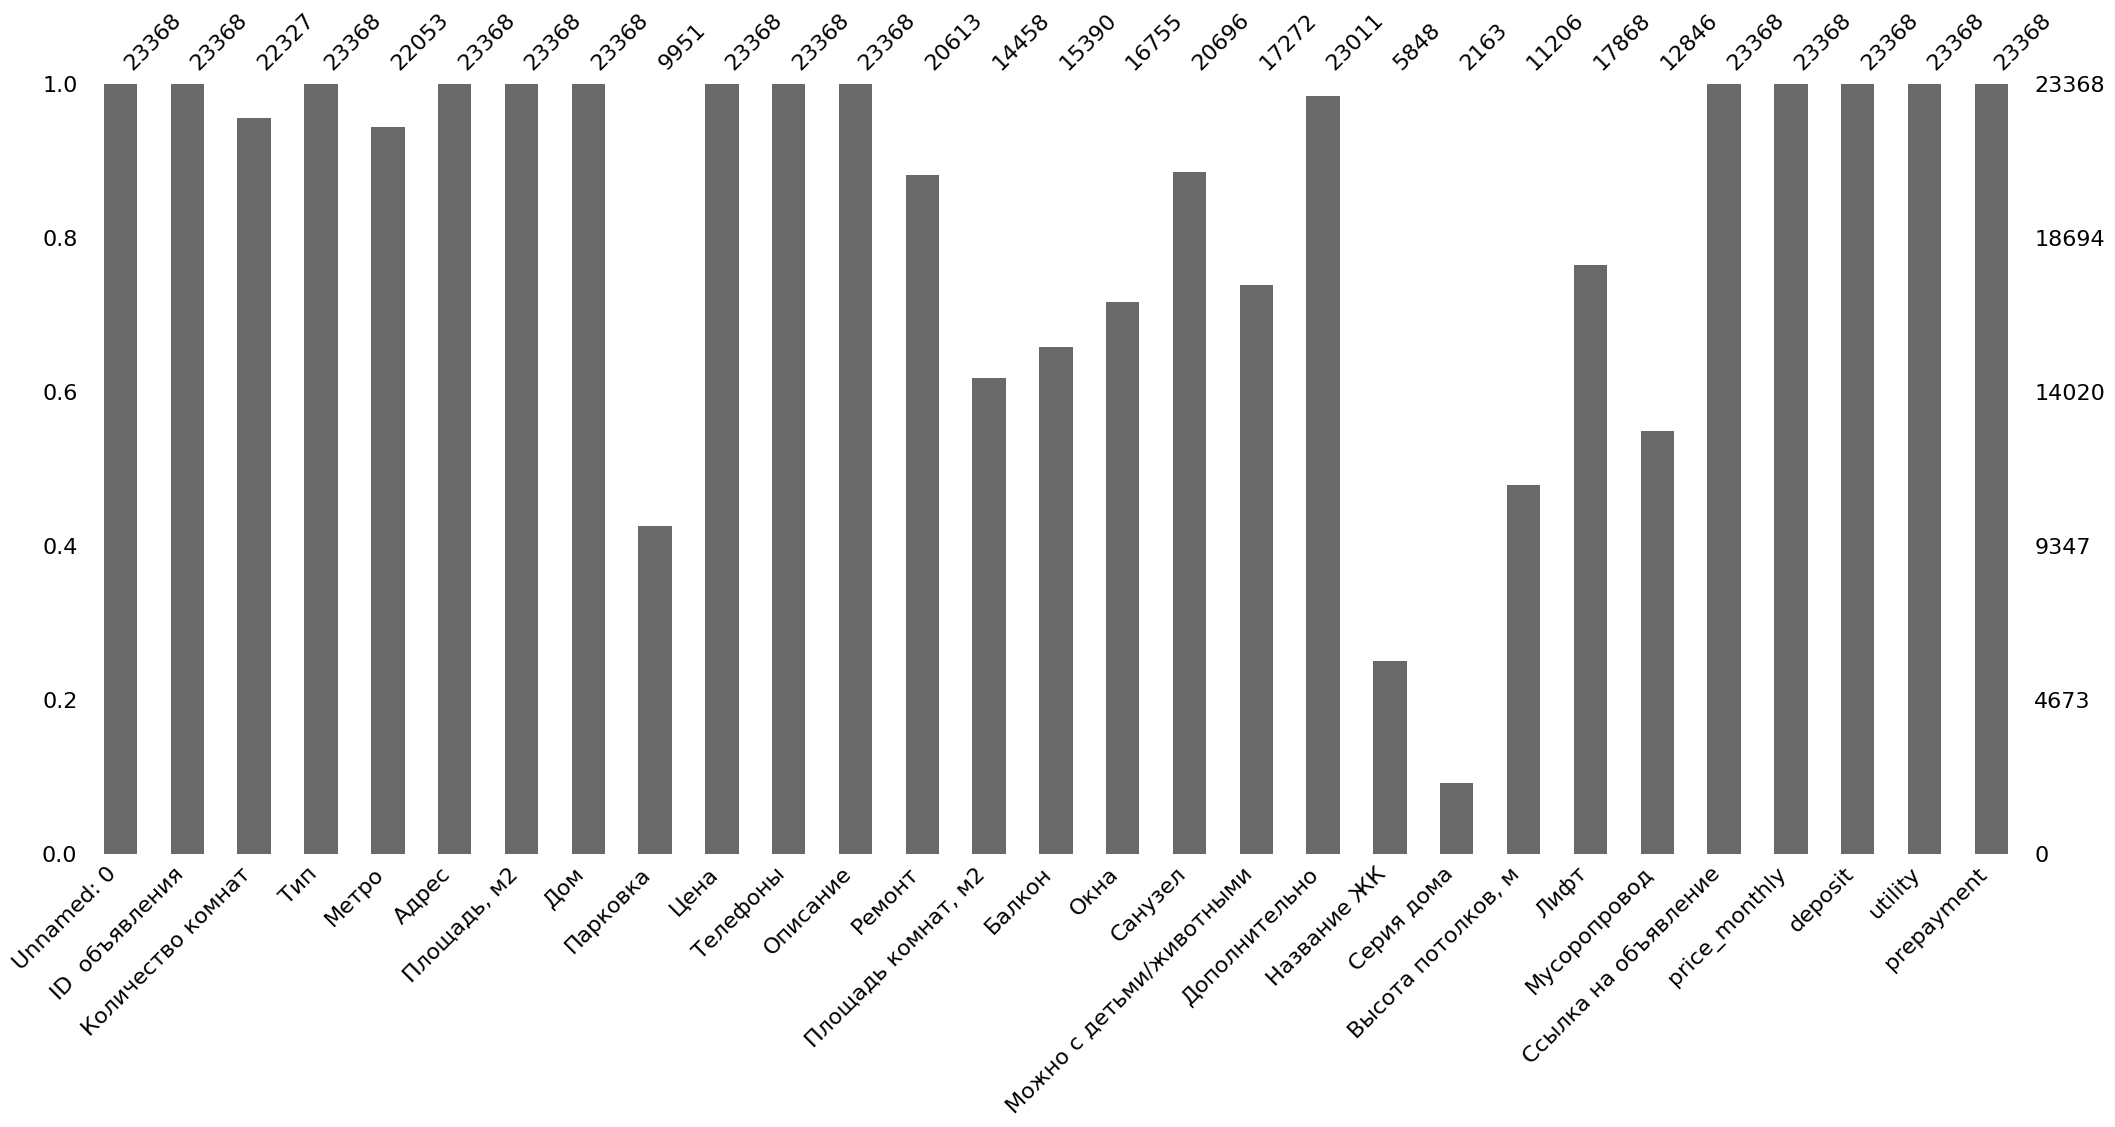

In [873]:
msno.bar(data)

In [874]:
data_clean = data.copy()

In [875]:
data_clean = data_clean.drop(columns = ['Название ЖК','Цена','Тип','Ссылка на объявление','Дополнительно', 'Unnamed: 0', 'Телефоны','ID  объявления','Описание'])

In [876]:
#перевести на англ. язык все колонки
data_clean.columns = [
    'number_of_rooms',
    'metro',
    'address',
    'area',
    'building',
    'parking',
    'renovation',
    'room_area',
    'balcony',
    'windows',
    'bathroom',
    'children/pets allowed',
    'building_series',
    'ceiling_height',
    'elevator',
    'trash_chute',
    'price_monthly',
    'deposit',
    'utility',
    'prepayment'
]

In [877]:
data_clean['number_of_rooms'] = data_clean['number_of_rooms'].str.extract(r'(\d+)') #очищу от букв столбец с кол-вом комнат

In [878]:
unique_values = data_clean['trash_chute'].unique()
unique_values

array(['Да', 'Нет', nan], dtype=object)

In [879]:
data_clean['trash_chute'] = data_clean['trash_chute'].replace({'Да': 1, 'Нет': 0, pd.NA: 0})

In [880]:
correlation = data_clean['price_monthly'].corr(data_clean['trash_chute'])
correlation

-0.12654849076962307

In [881]:
#отрицательный и низкий показатель коэф. корреляции, поэтому этот столбец можно исключить из выборки для машинного обучения

In [882]:
data_clean = data_clean.drop(columns = 'trash_chute')

In [883]:
data_clean['metro'] = data_clean['metro'].str.extract(r'(\d+)')

In [884]:
data_clean['metro'] = data_clean['metro'].astype(float)

In [885]:
mean_metro = data_clean['metro'].mean()
data_clean['metro'].fillna(mean_metro, inplace=True)

In [886]:
data_clean['prepayment'] #колонка была заполнена модой

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
23363    1.0
23364    1.0
23365    1.0
23366    2.0
23367    1.0
Name: prepayment, Length: 23368, dtype: float64

In [887]:
unique_values1 = data_clean['prepayment'].unique()
print(unique_values1)

[ 1.  2.  3. 11.  6. 12.]


In [888]:
data_clean['prepayment'].fillna(0, inplace=True)

In [889]:
data_clean.loc[data_clean['prepayment'] == 0, 'deposit'].fillna(0, inplace=True)#заполним пустые значения в предоплате 

In [890]:
data_clean = data_clean.drop(columns = 'building_series') #убираем тк не имеет важности

In [891]:
data_clean['area'] = data_clean['area'].apply(lambda x: x.split('/'))
data_clean['area'] = data_clean['area'].apply(lambda i: i[0])

In [892]:
data_clean['area'] = data_clean["area"].astype(float)

In [893]:
data_clean['number_of_rooms'] = data_clean['number_of_rooms'].fillna(data_clean['area']/40).astype(int)

In [894]:
data_clean = data_clean.drop(columns = 'room_area') 

In [895]:
data_clean = data_clean.drop(columns = 'prepayment') 

In [896]:
#случайные числа от 2.6 до 4.0 для заполнения NaN
random_values = np.random.uniform(2.6, 4.0, size=data_clean['ceiling_height'].isnull().sum())
#замена NaN случайными значениями от 2.6 до 4.0
data_clean.loc[data_clean['ceiling_height'].isnull(), 'ceiling_height'] = random_values

In [897]:
data_clean[['floors', 'type_house']] = data_clean['building'].str.split(', ', expand=True)
data_clean = data_clean.drop(columns = 'building') 

In [898]:
#неинформативными считаются признаки, в которых пропущено 20-30% информации, соответственно от балконов избавляемся

In [899]:
data_clean = data_clean.drop(columns=['balcony'])


In [900]:
data_clean[['current_floor', 'total_floors']] = data_clean['floors'].str.split('/', expand=True) #делим этажи
#на общее кол-во, и этаж опр. квартиры

In [901]:
data_clean = data_clean.drop(columns=['floors']) #исходный столбец убираем

In [902]:
data_clean['total_floors'] = data_clean['total_floors'].astype(int)
mask = data_clean['total_floors'] > 35
data_clean.loc[mask, 'total_floors'] = np.random.randint(9, 36, size=mask.sum())


In [903]:
unique_values1 = data_clean['total_floors'].unique()
unique_values1

array([16,  6, 26,  7,  5,  4, 10,  8,  9,  3, 13, 17, 12, 14, 11, 24, 15,
       22, 19, 18,  2, 23, 20, 21, 25, 30, 33, 28, 27, 29,  1, 35, 32, 31,
       34])

In [904]:
def elevators_value(row): #заполняем столбец с лифтами, из рассчета, что если больше 5 этажей - нужен 1 лифт. Больше 10 - 2 
    if pd.isna(row['elevator']):
        if int(row['total_floors']) >= 10:
            a = int(row['total_floors'])
            return f'Пасс {a//10}, Груз {a//10}'
        elif int(row['total_floors']) > 5:
            return 'Пасс (1)'
        else:
            return '0'
    else:
        return row['elevator']

data_clean['elevator'] = data_clean.apply(elevators_value, axis=1)

In [905]:
data_clean['elevator'] = np.random.randint(1, 5, size=len(data_clean))

In [906]:
data_clean.rename(columns={'children/pets allowed': 'children_pets_allowed'},inplace = True)

In [907]:
replace_dict = {
    'Можно с детьми': 1,
    'Можно с животными': 2,
    'Можно с детьми, Можно с животными': 3,
    '0': 0,  
}
data_clean['children_pets_allowed'] = data_clean['children_pets_allowed'].replace(replace_dict)
data_clean['children_pets_allowed']

0        3.0
1        1.0
2        1.0
3        2.0
4        NaN
        ... 
23363    NaN
23364    NaN
23365    1.0
23366    NaN
23367    3.0
Name: children_pets_allowed, Length: 23368, dtype: float64

In [908]:
correlation = data_clean['price_monthly'].corr(data_clean['children_pets_allowed'])
print(correlation) #низкая корреляция, убираем столбец

0.08942490532043243


In [909]:
data_clean = data_clean.drop(columns=['children_pets_allowed'])

In [910]:
windows_mapping = {None: -1, 'На улицу и двор': 0, 'Во двор': 1, 'На улицу': 2}
mode_windows = data_clean['windows'].mode()[0] #тут тоже используем моду
data_clean['windows'].fillna(mode_windows, inplace=True)

data_clean['windows'] = data_clean['windows'].map(windows_mapping)

In [911]:
renovation_mapping = {'Дизайнерский': 0, 'Евроремонт': 1, 'Косметический': 2, 'Без ремонта': 3}

# Заполняем пропущенные значения самым часто встречающимся
mode_renovation = data_clean['renovation'].mode()[0]
data_clean['renovation'].fillna(mode_renovation, inplace=True)

# Применяем map() для преобразования категорий в числа
data_clean['renovation'] = data_clean['renovation'].map(renovation_mapping)

In [912]:
def define_parking(row): #заполним парковку
    if pd.isna(row['parking']):
        if int(row['total_floors']) >= 15:
            return 'наземная'
        else:
            return 'подземная'
    else:
        return row['parking']

# Применение функции к DataFrame
data_clean['parking'] = data_clean.apply(define_parking, axis=1)

In [913]:
parking_mapping = {None: -1, 'подземная': 0, 'наземная': 1, 'открытая': 2, 'многоуровневая': 3, 'на крыше':4}
mode_parking = data_clean['parking'].mode()[0] #тут тоже используем моду
data_clean['parking'].fillna(mode_parking, inplace=True)

data_clean['parking'] = data_clean['parking'].map(parking_mapping)

In [914]:
unique_values1 = data_clean['type_house'].unique()
print(unique_values1)

['Монолитный' 'Монолитно-кирпичный' None 'Панельный' 'Сталинский'
 'Кирпичный' 'старый фонд' 'Блочный' 'Деревянный' 'Газобетонный блок'
 'Щитовой']


In [915]:
type_house_mapping = {None: -1, 'Монолитный': 0, 'Монолитно-кирпичный': 1, 'Панельный': 2, 'Сталинский': 3, 'Кирпичный':4, 'старый фонд':5,
                  'Блочный':6,'Деревянный':7,'Газобетонный блок':8,'Щитовой':9}
mode_type_house = data_clean['type_house'].mode()[0] #тут тоже используем моду
data_clean['type_house'].fillna(mode_type_house, inplace=True)

data_clean['type_house'] = data_clean['type_house'].map(type_house_mapping)

In [916]:
df['bathrooms_combined'] = data_clean['bathroom'].apply(lambda x: int(re.search(r'\d+', x).group()) if 'Совмещенный' in x else 0)

TypeError: argument of type 'float' is not iterable

<Axes: >

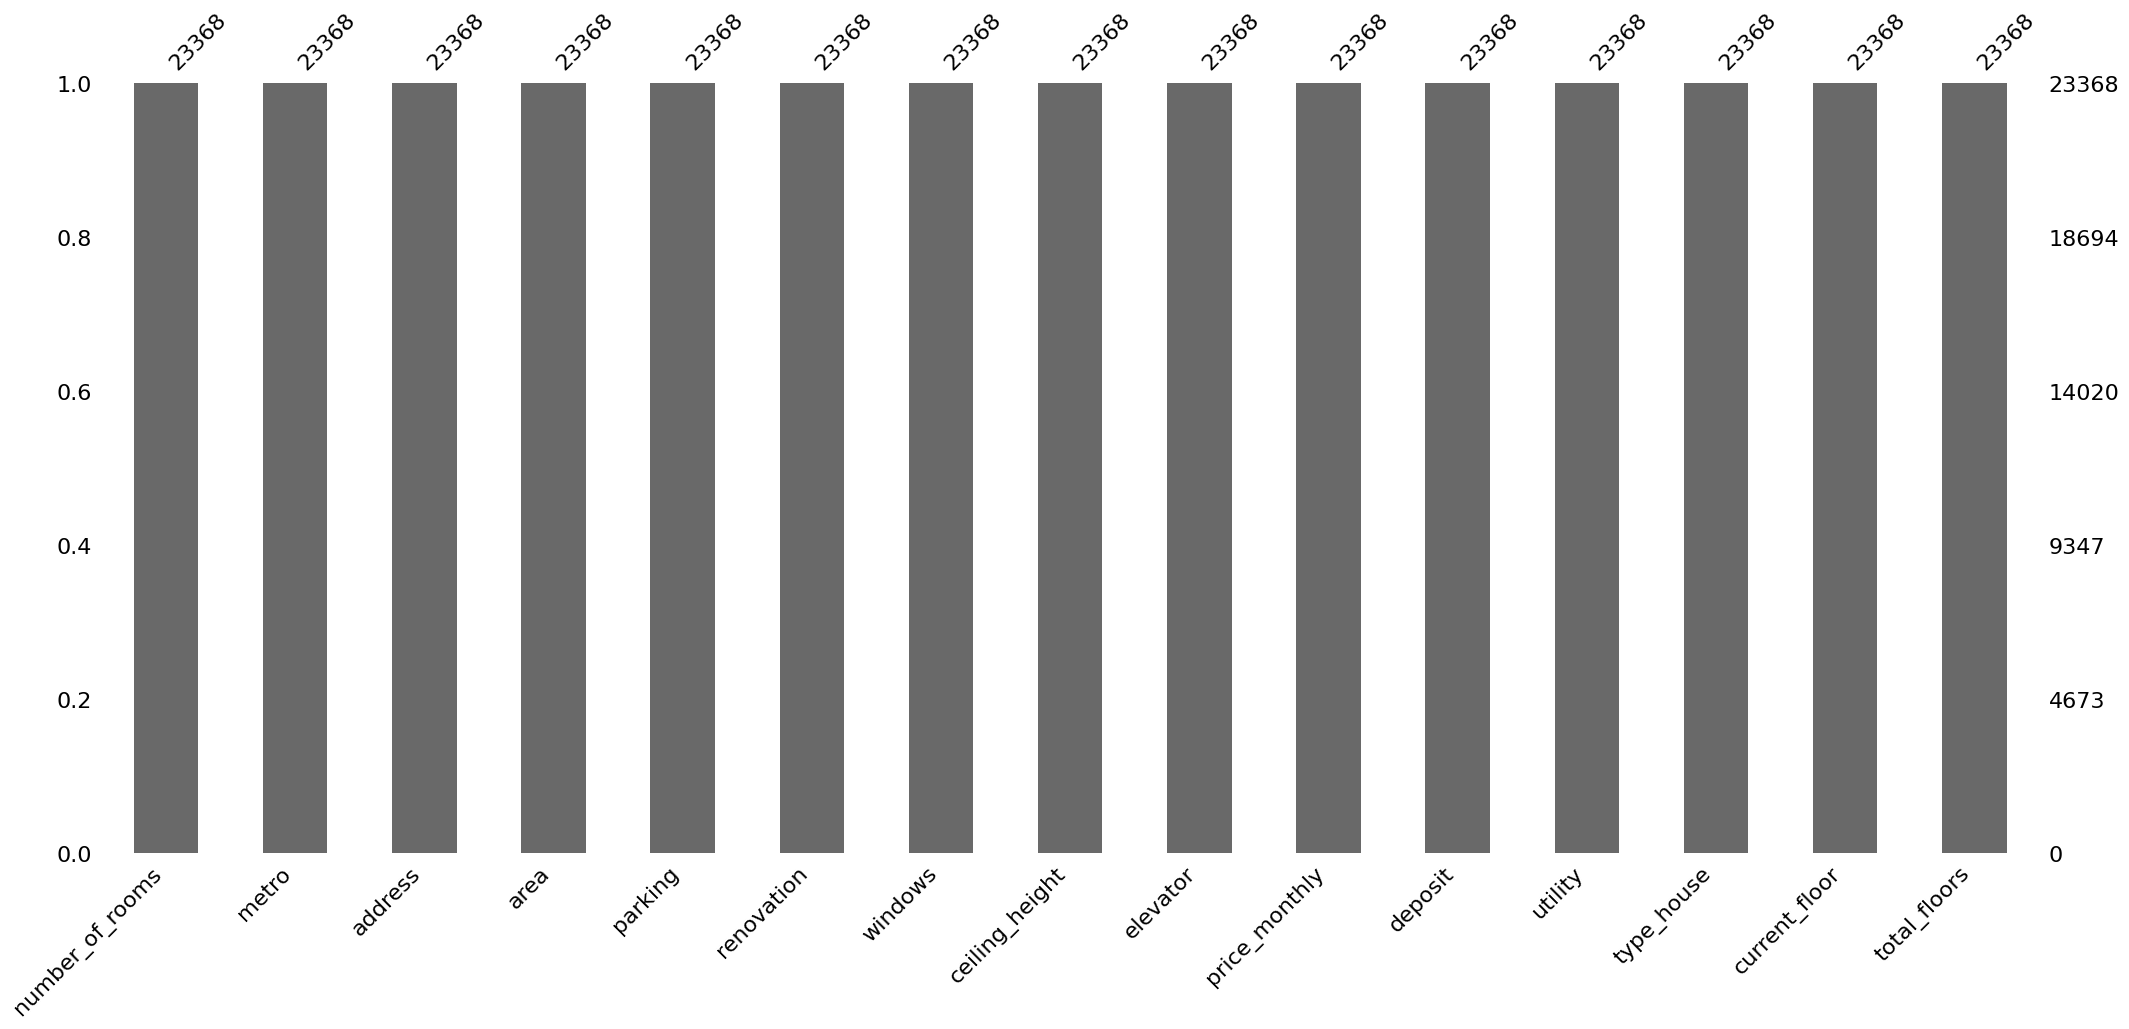

In [917]:
data_clean = data_clean.drop(columns=['bathroom']) 
msno.bar(data_clean) #на графике видно, что незаполненных значений у нас не осталось:)

In [918]:
data_clean.to_csv('clean_dataset.csv', index=False)

In [919]:
unique_values = data['Метро'].unique()
unique_values


array(['м. Смоленская (9 мин пешком)', 'м. Смоленская (8 мин пешком)',
       'м. Смоленская (7 мин пешком)', ...,
       'м. Боровское шоссе (5 мин на машине)',
       'м. Говорово (2 мин пешком)', 'м. Солнцево (5 мин на машине)'],
      dtype=object)

In [920]:
def extract_metro_info(row):
    if isinstance(row, str):
        parts = row.split('м. ')
        if len(parts) > 1:
            metro_station = parts[1].split('(')[0].strip()
            time_to_metro = re.search(r'(\d+)', row)
            travel_method = re.search(r'(пешком|на машине)', row)
            return metro_station, int(time_to_metro.group(1)) if time_to_metro else None, travel_method.group(1) if travel_method else None
    return None, None, None

data[['Станция метро', 'Время до метро (мин)', 'Способ передвижения']] = data['Метро'].apply(lambda x: pd.Series(extract_metro_info(x)))

data['Время до метро (мин)'] = data['Время до метро (мин)'].astype(float)

data[['Метро', 'Станция метро', 'Время до метро (мин)', 'Способ передвижения']].head()

,Метро,Станция метро,Время до метро (мин),Способ передвижения
0,м. Смоленская (9 мин пешком),Смоленская,9.0,пешком
1,м. Смоленская (8 мин пешком),Смоленская,8.0,пешком
2,м. Смоленская (7 мин пешком),Смоленская,7.0,пешком
3,м. Смоленская (3 мин пешком),Смоленская,3.0,пешком
4,м. Арбатская (7 мин пешком),Арбатская,7.0,пешком


In [921]:
unique_values = data['Способ передвижения'].unique()
unique_values

array(['пешком', None, 'на машине'], dtype=object)

In [922]:
metro_codes_excel = pd.read_excel('./data-1488-2999-01-01.xlsx')
metro_codes_subset = metro_codes_excel[['ID', 'Station', "District"]]
metro_codes_subset['District'] = metro_codes_subset['District'].str.replace('район', '', regex=True).str.strip()
metro_codes_subset 


/Users/katyyyas/miniforge3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/xn/75c4nqs10sqdpk4714mqnlj00000gn/T/ipykernel_6087/1217684441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metro_codes_subset['District'] = metro_codes_subset['District'].str.replace('район', '', regex=True).str.strip()


,ID,Station,District
0,Код,Наименование станции,Район
1,136,Третьяковская,Замоскворечье
2,86,Медведково,Северное Медведково
3,41,Первомайская,Измайлово
4,104,Калужская,Обручевский
...,...,...,...
301,323,Кленовый бульвар,Нагатинский Затон
302,328,Пыхтино,поселение Внуковское
303,325,Аэропорт Внуково,Внуково
304,326,Яхромская,Восточное Дегунино


In [923]:
#print(data.columns)

# Объединение data и metro_codes_subset по названиям станций метро и району
# Удаляем столбец 'Метро'
data.drop('Метро', axis=1, inplace=True)

# Объединяем data и metro_codes_subset по столбцу 'Станция метро'
data = data.merge(metro_codes_subset[['Station', 'District']], left_on='Станция метро', right_on='Station', how='left')

print(data.columns)

Index(['Unnamed: 0', 'ID  объявления', 'Количество комнат', 'Тип', 'Адрес',
       'Площадь, м2', 'Дом', 'Парковка', 'Цена', 'Телефоны', 'Описание',
       'Ремонт', 'Площадь комнат, м2', 'Балкон', 'Окна', 'Санузел',
       'Можно с детьми/животными', 'Дополнительно', 'Название ЖК',
       'Серия дома', 'Высота потолков, м', 'Лифт', 'Мусоропровод',
       'Ссылка на объявление', 'price_monthly', 'deposit', 'utility',
       'prepayment', 'Станция метро', 'Время до метро (мин)',
       'Способ передвижения', 'Station', 'District'],
      dtype='object')


In [929]:
data_clean.drop('address', axis=1, inplace=True)

KeyError: "['address'] not found in axis"

In [931]:
data_clean.drop('utility', axis=1, inplace=True)

In [932]:
data_clean

,number_of_rooms,metro,area,parking,renovation,windows,ceiling_height,elevator,price_monthly,deposit,type_house,current_floor,total_floors
0,4,9.0,200.0,0,0,1,3.000000,1,500000.0,500000.0,0,5,16
1,4,8.0,198.0,0,0,0,3.500000,4,500000.0,500000.0,1,5,16
2,4,7.0,200.0,0,1,0,3.200000,2,500000.0,500000.0,2,5,16
3,4,3.0,170.0,0,1,0,3.200000,4,400000.0,400000.0,2,5,6
4,2,7.0,58.0,1,1,0,3.900000,3,225000.0,225000.0,2,12,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23363,0,8.0,35.0,0,1,1,3.790728,2,42000.0,42000.0,2,10,14
23364,1,7.0,38.7,1,1,1,3.206225,3,45000.0,45000.0,0,5,18
23365,2,6.0,43.1,0,0,0,3.498089,1,50000.0,50000.0,4,5,5
23366,2,11.0,52.5,1,1,1,2.650000,1,55000.0,50000.0,0,8,23


In [933]:
data_clean.to_csv('clean_dataset1.csv', index=False)